## Initialization

In [ ]:
!mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

!wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.

!tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.

!pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

In [2]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
import numpy as np

nusc = NuScenes(version='v1.0-mini', dataroot='/data/raw/full-dataset/mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.622 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [3]:
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap

nusc_map = NuScenesMap(dataroot='/data/raw/map-expansion', map_name='boston-seaport')

In [4]:
class Instance():
  def __init__(self, timestamp, sample_record, annotation_token, ego_pose_token, annotation_token2=None, annotation_token3=None):
    self.timestamp = timestamp
    self.sample_record = sample_record
    self.annotation_token = annotation_token
    self.annotation_token2 = annotation_token2
    self.annotation_token3 = annotation_token3
    self.ego_pose_token = ego_pose_token

In [5]:
from pyquaternion import Quaternion
import math

def normalizeAngle(angle) -> float:
    while angle > math.pi:
        angle -= math.tau
    while angle < -math.pi:
        angle += math.tau
    assert -math.pi <= angle <= math.pi
    return angle

def get_heading(rotation):
    yaw = Quaternion(rotation).yaw_pitch_roll[0]
    return normalizeAngle(yaw)

In [6]:
def get_road_direction(position):
  x, y, z = position
  closest_lane = nusc_map.get_closest_lane(x, y, radius=2)
  if closest_lane:
    lane_record = nusc_map.get_arcline_path(closest_lane)
    poses = arcline_path_utils.discretize_lane(lane_record, resolution_meters=1)
    closest_pose_on_lane, distance_along_lane = arcline_path_utils.project_pose_to_lane((x, y, 0), lane_record)
    yaw = closest_pose_on_lane[2]
    return normalizeAngle(yaw)
  else:
    return None  

In [7]:
def is_contained(position, segment_type):
  x, y, z = position
  return nusc_map.layers_on_point(x, y)[segment_type] != ''

In [8]:
def is_contained_intersection(position):
  x, y, z = position
  road_segment_token = nusc_map.layers_on_point(x, y)['road_segment']
  if road_segment_token != '':
    road_segment = nusc_map.get('road_segment', road_segment_token)
    return road_segment["is_intersection"]
  else:
    return False

In [9]:
from nuscenes.utils.geometry_utils import view_points, box_in_image, BoxVisibility, transform_matrix

def is_visible(sample_record, annotation_token):
  camera = sample_record["data"]["CAM_FRONT"]
  _, boxes, _ = nusc.get_sample_data(camera, box_vis_level=BoxVisibility.ANY, selected_anntokens=[annotation_token])
  return len(boxes) > 0

In [10]:
def convert_camera(cam_position, cam_heading, obj_point):
    cam_x, cam_y, _ = cam_position
    obj_x, obj_y, _ = obj_point
    
    subtract_x = obj_x - cam_x
    subtract_y = obj_y - cam_y

    subtract_mag = np.sqrt(subtract_x**2 + subtract_y**2)

    res_x = subtract_mag * np.cos(-cam_heading + np.arctan2(subtract_y, subtract_x))
    res_y = subtract_mag * np.sin(-cam_heading + np.arctan2(subtract_y, subtract_x))

    return res_x, res_y

## Figure 12


In [ ]:
# world = world.filter(
#     F.like(o.type, lit('human.pedestrian%')) &
#     F.contained(c.ego, 'road') &
#     (F.contained_margin(o.bbox@c.time, F.road_segment('road'), lit(0.50)) | F.contained(o.trans@c.time, 'road')) &
#     F.angle_excluding(F.facing_relative(o.traj@c.time, c.ego), lit(-70), lit(70)) &
#     F.angle_between(F.facing_relative(c.ego, c.roadDirection), lit(-15), lit(15)) &
#     (F.distance(c.camAbs, o.traj@c.time) < lit(50)) &
#     (F.view_angle(o.trans@c.time, c.camAbs) < lit(35))
# )

In [ ]:
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50, 
#         with viewAngle 135 deg
# ped = Pedestrian on roadsOrIntersections,
#         with regionContainedIn roadRegion,
#         facing Range(-180, 180) deg

# require abs(relative heading of ped from ego) > 70 deg

In [ ]:
### Devkit Plan
# 1. Get all instances of Egos
#     - such that on road (prob not needed)
#     - such that facing Range(-15, 15) relative to roadDirection
# 2. Geet all instances of pedestrians wrt egos
#     - such that withitn 50 meters of ego
#     - such that on road
#     - such that visibile from ego (viewAngle if needed)

In [26]:
## Get all possible pedestrian + ego instances
instances = []
for sample in nusc.sample:
  scene = nusc.get('scene', sample['scene_token'])
  log = nusc.get('log', scene['log_token'])
  if log['location'] == 'boston-seaport':
    for annotation in sample['anns']:
      annotation_metadata = nusc.get('sample_annotation', annotation)
      if 'human.pedestrian' in annotation_metadata['category_name']:
        CAM_FRONT_SENSOR = sample['data']['CAM_FRONT']
        sample_data = nusc.get('sample_data', CAM_FRONT_SENSOR)
        ego_pose_token = sample_data['ego_pose_token']
        instances.append(Instance(timestamp=sample_data['timestamp'], sample_record=sample, annotation_token=annotation, ego_pose_token=ego_pose_token))
len(instances)

1591

In [27]:
## Filter for pedestrians that are within 50 meters of the ego
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation = nusc.get('sample_annotation', instance.annotation_token)

  ped_trans = np.array(annotation['translation'])
  ego_trans = np.array(ego_pose['translation'])
  distance = np.linalg.norm(ped_trans - ego_trans)

  if distance < 50:
    new_instances.append(instance)
instances = new_instances
len(instances)

1260

In [28]:
## Filter so that pedestrian is visible from ego
new_instances = []
for instance in instances:
  ped_visible = is_visible(sample_record=instance.sample_record, annotation_token=instance.annotation_token)
  if ped_visible:
    new_instances.append(instance)
instances = new_instances
len(instances)

295

In [29]:
## Filter so that for pedestrians that are on a road
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation = nusc.get('sample_annotation', instance.annotation_token)

  ped_trans = np.array(annotation['translation'])
  ego_trans = np.array(ego_pose['translation'])
  
  if is_contained(ped_trans, 'road_segment'):
    new_instances.append(instance)
instances = new_instances
len(instances)

126

In [30]:
## Filter for egos whos heading is aligned with the road direction
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation = nusc.get('sample_annotation', instance.annotation_token)

  ped_trans = np.array(annotation['translation'])
  ego_trans = np.array(ego_pose['translation'])
  
  ego_heading = get_heading(ego_pose['rotation'])
  road_direction = get_road_direction(ego_trans)
  if road_direction == None:
    new_instances.append(instance)
  elif normalizeAngle(abs(ego_heading - road_direction)) < math.radians(15):
    new_instances.append(instance)
instances = new_instances
len(instances)

125

In [31]:
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation = nusc.get('sample_annotation', instance.annotation_token)

  ped_trans = np.array(annotation['translation'])
  ego_trans = np.array(ego_pose['translation'])
  
  ego_heading = get_heading(ego_pose['rotation'])
  ped_heading = get_heading(annotation['rotation'])
  if abs(normalizeAngle(ego_heading - ped_heading)) > math.radians(70):
    new_instances.append(instance)
instances = new_instances
len(instances)

115

In [32]:
results = {}
for instance in instances:
  camera_token = instance.sample_record['data']['CAM_FRONT']
  camera_data = nusc.get('sample_data', camera_token)
  results[camera_data['token']] = camera_data['filename']

In [ ]:
for token in results:
  nusc.render_sample_data(token)

In [33]:
############# Validation ####################
expected_imgs = ['samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489302512404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489303412404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489310362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489307412404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489306412404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489311862404.jpg',
 'samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604512404.jpg',
 'samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151603512404.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385100362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489304412404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489303912404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489303012421.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385101362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489307912404.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385098862404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489305912404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489313362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385097362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605512404.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385097862411.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385099362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489309362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151606512404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489305412404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489309862404.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385099862404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489312862404.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385098362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-27-11-48-51-0400__CAM_FRONT__1535385100862404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489311362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489304912404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489308362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489306912404.jpg',
 'samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151605012404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489308862404.jpg',
 'samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151606012404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489312362404.jpg',
 'samples/CAM_FRONT/n008-2018-08-01-15-16-36-0400__CAM_FRONT__1533151604012404.jpg',
 'samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489310912404.jpg']

missing = 0
missing_images = []
for expected_img in expected_imgs:
    if expected_img not in results.values():
        missing += 1
        # missing_images.append(expected_img)
print("Percentage of expected results missing from query: ", missing, "/", len(expected_imgs), "=", 100 * missing / len(expected_imgs), "%")
# show_images(missing_images, sample=10)

extra = 0
extra_images = {}
for img in results:
    if results[img] not in expected_imgs:
        extra += 1
        # extra_images[img] = resultImages[img]
print("Percentage of images in query but not in expected results: ", extra, "/", len(results), "=", 100 * extra / len(results), "%")
# show_images(extra_images.keys(), sample=10)

Percentage of expected results missing from query:  0 / 39 = 0.0 %
Percentage of images in query but not in expected results:  0 / 39 = 0.0 %


In [ ]:
fig, ax = nusc_map.render_layers(nusc_map.non_geometric_layers, figsize=1)

## Figure 13


In [ ]:
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# other1 = Car on intersection,
#             facing Range(50, 135) deg relative to ego.heading

# other2 = Car on intersection,
#             facing -1 * Range(50, 135) deg relative to ego.heading

# require abs(relative heading of other1 from other2) > 100 deg
# require (distance from ego to intersectionRegion) < 10

In [ ]:
# world = world.filter(
#     (obj1.id != obj2.id) &
#     F.like(obj1.type, 'vehicle%') &
#     F.like(obj2.type, 'vehicle%') &
#     F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.ego)), -15, 15) &
#     (F.distance(cam.ego, obj1.trans@cam.time) < 50) &
#     (F.view_angle(obj1.trans@cam.time, cam.ego) < 70 / 2.0) &
#     (F.distance(cam.ego, obj2.trans@cam.time) < 50) &
#     (F.view_angle(obj2.trans@cam.time, cam.ego) < 70 / 2.0) &
#     F.contains_all('intersection', [obj1.trans, obj2.trans]@cam.time) &
#     F.angle_between(F.facing_relative(obj1.trans@cam.time, cam.ego), 50, 135) &
#     F.angle_between(F.facing_relative(obj2.trans@cam.time, cam.ego), -135, -50) &
#     (F.min_distance(cam.ego, F.road_segment('intersection')) < 10) &
#     F.angle_between(F.facing_relative(obj1.trans@cam.time, obj2.trans@cam.time), 100, -100)
# )

In [29]:
## Get all possible car1 + car2 instances
instances = []
for sample in nusc.sample:
  scene = nusc.get('scene', sample['scene_token'])
  log = nusc.get('log', scene['log_token'])
  if log['location'] == 'boston-seaport': # scene['name'] == 'scene-0757' and 
    if log['location'] == 'boston-seaport':
      for annotation1 in sample['anns']:
        for annotation2 in sample['anns']:
          annotation_metadata1 = nusc.get('sample_annotation', annotation1)
          annotation_metadata2 = nusc.get('sample_annotation', annotation2)
          if annotation_metadata1['category_name'] == 'vehicle.car' or annotation_metadata1['category_name'] == 'vehicle.bus.rigid' or annotation_metadata1['category_name'] == 'vehicle.truck':
            if annotation_metadata2['category_name'] == 'vehicle.car' or annotation_metadata1['category_name'] == 'vehicle.bus.rigid' or annotation_metadata2['category_name'] == 'vehicle.truck':
              CAM_FRONT_SENSOR = sample['data']['CAM_FRONT']
              sample_data = nusc.get('sample_data', CAM_FRONT_SENSOR)
              ego_pose_token = sample_data['ego_pose_token']
              instances.append(Instance(timestamp=sample_data['timestamp'], sample_record=sample, annotation_token=annotation1, annotation_token2=annotation2, ego_pose_token=ego_pose_token))
len(instances)

135936

In [30]:
## Filter for cars  that are within 50 meters of the ego
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation1 = nusc.get('sample_annotation', instance.annotation_token)
  annotation2 = nusc.get('sample_annotation', instance.annotation_token2)

  car1_trans = np.array(annotation1['translation'])
  car2_trans = np.array(annotation2['translation'])
  ego_trans = np.array(ego_pose['translation'])
  distance1 = np.linalg.norm(car1_trans - ego_trans)
  distance2 = np.linalg.norm(car2_trans - ego_trans)

  if distance1 < 50 and distance2 < 50:
    new_instances.append(instance)
instances = new_instances
len(instances)

82759

In [31]:
## Filter so that cars are visible from ego
new_instances = []
for instance in instances:
  car1_visible = is_visible(sample_record=instance.sample_record, annotation_token=instance.annotation_token)
  car2_visible = is_visible(sample_record=instance.sample_record, annotation_token=instance.annotation_token2)
  if car1_visible and car2_visible:
    new_instances.append(instance)
instances = new_instances
len(instances)

6896

In [32]:
## Filter for relative headings wrt to ego
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation1 = nusc.get('sample_annotation', instance.annotation_token)
  annotation2 = nusc.get('sample_annotation', instance.annotation_token2)

  
  ego_heading = get_heading(ego_pose['rotation'])
  car1_heading = get_heading(annotation1['rotation'])
  car2_heading = get_heading(annotation2['rotation'])
  
  car1_diff = normalizeAngle(ego_heading - car1_heading)
  car2_diff = normalizeAngle(ego_heading - car2_heading)
  
  if math.radians(50) < car1_diff and car1_diff < math.radians(135):
    if math.radians(-135) < car2_diff and car2_diff < math.radians(-50):
      if abs(car1_heading - car2_heading) > math.radians(100):
        new_instances.append(instance)
instances = new_instances
len(instances)

233

In [33]:
## Filter so that for cars that are in an intersection
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation1 = nusc.get('sample_annotation', instance.annotation_token)
  annotation2 = nusc.get('sample_annotation', instance.annotation_token2)

  car1_trans = np.array(annotation1['translation'])
  car2_trans = np.array(annotation2['translation'])
  ego_trans = np.array(ego_pose['translation'])
  
  if is_contained_intersection(car1_trans) and is_contained_intersection(car2_trans):
    new_instances.append(instance)
instances = new_instances
len(instances)

22

In [34]:
## Filter for egos whos heading is aligned with the road direction
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation = nusc.get('sample_annotation', instance.annotation_token)

  ped_trans = np.array(annotation['translation'])
  ego_trans = np.array(ego_pose['translation'])
  
  ego_heading = get_heading(ego_pose['rotation'])
  road_direction = get_road_direction(ego_trans)
  if road_direction == None:
    new_instances.append(instance)
  elif normalizeAngle(abs(ego_heading - road_direction)) < math.radians(15):
    new_instances.append(instance)
instances = new_instances
len(instances)

22

In [35]:
results = {}
for instance in instances:
  camera_token = instance.sample_record['data']['CAM_FRONT']
  camera_data = nusc.get('sample_data', camera_token)
  results[camera_data['token']] = camera_data['filename'] # .split('/')[2]

In [36]:
for token in results:
  print(results[token])
  # nusc.render_sample_data(token)

samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657117612404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118612404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119112404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119612404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657120112404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657120612404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657121112404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657121612404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657122112404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657122612404.jpg
samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657123112404.jpg
samples/CAM_FRONT/n008-2018-

In [37]:
############# Validation ####################
expected_imgs = ['samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657122112404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657121112404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657121612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657118112404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119112404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657123612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657119612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657120612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657122612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657117612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657120112404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657123112404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657124112404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657127612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657128112404.jpg']

expected_imgs = [x for x in expected_imgs if "samples" in x]

missing = 0
missing_images = []
for expected_img in expected_imgs:
    if expected_img not in results.values():
        missing += 1
        print("Missing", expected_img)
        # missing_images.append(expected_img)
print("Percentage of expected results missing from query: ", missing, "/", len(expected_imgs), "=", 100 * missing / len(expected_imgs), "%")
# show_images(missing_images, sample=10)

extra = 0

extra_images = {}
for img in results:
    if results[img] not in expected_imgs:
        extra += 1
        # extra_images[img] = resultImages[img]
print("Percentage of images in query but not in expected results: ", extra, "/", len(results), "=", 100 * extra / len(results), "%")
# show_images(extra_images.keys(), sample=10)

Percentage of expected results missing from query:  0 / 16 = 0.0 %
Percentage of images in query but not in expected results:  0 / 16 = 0.0 %


In [ ]:
print(list(results.values()))

In [ ]:
fig, ax = nusc_map.render_layers(nusc_map.non_geometric_layers, figsize=1)

In [ ]:
nusc.list_scenes()

## Figure 14


In [ ]:
# ego = Car on drivableRoad,
#         facing offset relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# otherCar = Car on visible road,
#             facing Range(-15, 15) deg relative to roadDirection

# require (distance from ego to otherCar) < 10

In [ ]:
# world = world.filter("lambda obj1, cam: " + 
#         "F.like(obj1.object_type, 'vehicle%') and " +
#         "F.distance(cam.ego, obj1, cam.timestamp) < 50 and " +
#         "F.view_angle(obj1, cam.ego, cam.timestamp) < 70 / 2 and " +
#         "F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.timestamp, cam.ego), cam.timestamp), -180, -90) and " +
#         "F.contained(cam.ego, F.road_segment('road')) and " +
#         "F.contained(obj1.traj, F.road_segment('road'), cam.timestamp) and " +
#         "F.angle_between(F.facing_relative(obj1, F.road_direction(obj1.traj, cam.timestamp, cam.ego), cam.timestamp), -15, 15) and " +
#         "F.distance(cam.ego, obj1, cam.timestamp) < 10"
# )

In [ ]:
## Get all possible car + ego instances
instances = []
for sample in nusc.sample:
  scene = nusc.get('scene', sample['scene_token'])
  log = nusc.get('log', scene['log_token'])
  if log['location'] == 'boston-seaport' and scene["name"] == "scene-0769":
    for annotation in sample['anns']:
      annotation_metadata = nusc.get('sample_annotation', annotation)
      if annotation_metadata['category_name'] == 'vehicle.car' or annotation_metadata['category_name'] == 'vehicle.bus.rigid' or annotation_metadata['category_name'] == 'vehicle.truck':
        CAM_FRONT_SENSOR = sample['data']['CAM_FRONT']
        sample_data = nusc.get('sample_data', CAM_FRONT_SENSOR)
        ego_pose_token = sample_data['ego_pose_token']
        instances.append(Instance(timestamp=sample_data['timestamp'], sample_record=sample, annotation_token=annotation, ego_pose_token=ego_pose_token))
len(instances)

In [ ]:
## Filter for cars  that are within 10 meters of the ego
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation1 = nusc.get('sample_annotation', instance.annotation_token)

  car1_trans = np.array(annotation1['translation'])
  ego_trans = np.array(ego_pose['translation'])
  distance1 = np.linalg.norm(car1_trans - ego_trans)

  if distance1 < 50:
    new_instances.append(instance)
instances = new_instances
len(instances)

In [ ]:
## Filter so that cars are visible from ego
new_instances = []
for instance in instances:
  car1_visible = is_visible(sample_record=instance.sample_record, annotation_token=instance.annotation_token)
  if car1_visible:
    new_instances.append(instance)
instances = new_instances
len(instances)

In [ ]:
## Filter for cars whos heading is aligned with the road direction
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation = nusc.get('sample_annotation', instance.annotation_token)

  car_trans = np.array(annotation['translation'])
  ego_trans = np.array(ego_pose['translation'])
  
  
  car_heading = get_heading(annotation['rotation'])
  road_direction = get_road_direction(car_trans)
  if road_direction == None:
    new_instances.append(instance)
  elif math.radians(-15) < normalizeAngle(abs(car_heading - road_direction)) and normalizeAngle(abs(car_heading - road_direction)) < math.radians(15):
    new_instances.append(instance)
instances = new_instances
len(instances)

In [ ]:
## Filter for egos who are moving in opposite direction
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation = nusc.get('sample_annotation', instance.annotation_token)
  
  ego_trans = np.array(ego_pose['translation'])

  road_direction = get_road_direction(ego_trans)
  ego_heading = get_heading(ego_pose['rotation'])
  if road_direction == None:
    new_instances.append(instance)
    continue
  diff = normalizeAngle(ego_heading - road_direction) 
  if (math.radians(-180) < diff and diff < math.radians(-90)) or (math.radians(90) < diff and diff < math.radians(180)):
    new_instances.append(instance)
instances = new_instances
len(instances)

In [ ]:
results = {}
for instance in instances:
  camera_token = instance.sample_record['data']['CAM_FRONT']
  camera_data = nusc.get('sample_data', camera_token)
  results[camera_data['token']] = camera_data['filename'] #.split('/')[2]

In [ ]:
for token in results:
  print(results[token])
  nusc.render_sample_data(token)

In [ ]:
############# Validation ####################
expected_imgs = ['sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490862404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490912404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657490912404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491012404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491112404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491162404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491262404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491262404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491362404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491362404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491412404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491412404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491512404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491512404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491612404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491612404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491662404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491662404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491762404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491762404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491862404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491862404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491912404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491912404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492012404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492012404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492112404.jpg',
 'samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492112404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492162404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492162404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492262404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492262404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492362404.jpg',
 'sweeps/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657492412404.jpg']

expected_imgs = list(set([x for x in expected_imgs if "samples" in x]))

missing = 0
missing_images = []
for expected_img in expected_imgs:
    if expected_img not in results.values():
        missing += 1
        # missing_images.append(expected_img)
print("Percentage of expected results missing from query: ", missing, "/", len(expected_imgs), "=", 100 * missing / len(expected_imgs), "%")
# show_images(missing_images, sample=10)

extra = 0
extra_images = []
for img in results:
    if results[img] not in expected_imgs:
        extra += 1
        extra_images.append(results[img])
print("Percentage of images in query but not in expected results: ", extra, "/", len(results), "=", 100 * extra / len(results), "%")
# show_images(extra_images.keys(), sample=10)

In [ ]:
print(results.values())
print(expected_imgs)

In [ ]:
print('samples/CAM_FRONT/n008-2018-08-30-15-16-55-0400__CAM_FRONT__1535657491612404.jpg' in results.values())

In [ ]:
extra_images

In [ ]:
print(list(results.values()))

In [ ]:
fig, ax = nusc_map.render_layers(nusc_map.non_geometric_layers, figsize=1)

In [ ]:
nusc.list_scenes()

## Figure 15


In [ ]:
# ego = Car on drivableRoad,
#         facing Range(-15, 15) deg relative to roadDirection,
#         with visibleDistance 50,
#         with viewAngle 135 deg

# point1 = OrientedPoint ahead of ego by Range(0, 40)
# Car at (point1 offset by Range(-1, 1) @ 0),
#     facing Range(-15, 15) deg relative to roadDirection

In [ ]:
# world = world.filter(
#     (F.like(car1.type, 'car') | F.like(car1.type, 'truck')) &
#     (F.like(car2.type, 'car') | F.like(car2.type, 'truck')) &
#     (F.like(opposite_car.type, 'car') | F.like(opposite_car.type, 'truck')) &
#     (opposite_car.id != car2.id) &
#     (car1.id != car2.id) &
#     (car1.id != opposite_car.id) &

#     F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.ego)), -15, 15) &
#     (F.view_angle(car1.traj@cam.time, cam.ego) < 70 / 2) &
#     (F.distance(cam.ego, car1.traj@cam.time) < 50) &
# #     F.angle_between(F.facing_relative(car1.traj@cam.time, cam.ego), -15, 15) &
# #     F.angle_between(F.facing_relative(car1.traj@cam.time, F.road_direction(car1.traj@cam.time, cam.ego)), -15, 15) &
#     F.ahead(car1.traj@cam.time, cam.ego) &
#     F.angle_between(F.facing_relative(cam.ego, F.road_direction(cam.ego, cam.ego)), -15, 15) &
#     (F.convert_camera(opposite_car.traj@cam.time, cam.ego) > [-10, 0]) &
#     (F.convert_camera(opposite_car.traj@cam.time, cam.ego) < [-1, 50]) &
#     F.angle_between(F.facing_relative(opposite_car.traj@cam.time, cam.ego), 140, 180) &
#     (F.distance(opposite_car@cam.time, car2@cam.time) < 40) &
# #     F.angle_between(F.facing_relative(car2.traj@cam.time, F.road_direction(car2.traj@cam.time, cam.ego)), -15, 15) &
#     F.ahead(car2.traj@cam.time, opposite_car.traj@cam.time)
# )

In [11]:
## Get all possible car + car + car + ego instances
instances = []
for sample in nusc.sample:
  scene = nusc.get('scene', sample['scene_token'])
  log = nusc.get('log', scene['log_token'])
  if log['location'] == 'boston-seaport' and scene["name"] == "scene-0207":
    for annotation1 in sample['anns']:
      for annotation2 in sample['anns']:
        for annotation3 in sample['anns']:
          annotation1_metadata = nusc.get('sample_annotation', annotation1)
          annotation2_metadata = nusc.get('sample_annotation', annotation2)
          annotation3_metadata = nusc.get('sample_annotation', annotation3)
          if annotation1 != annotation2 and annotation2 != annotation3 and annotation1 != annotation3:
            if (annotation1_metadata['category_name'] == 'vehicle.car' or annotation1_metadata['category_name'] == 'vehicle.truck') \
              and (annotation2_metadata['category_name'] == 'vehicle.car' or annotation2_metadata['category_name'] == 'vehicle.truck') \
              and (annotation3_metadata['category_name'] == 'vehicle.car' or annotation3_metadata['category_name'] == 'vehicle.truck'):
              CAM_FRONT_SENSOR = sample['data']['CAM_FRONT']
              sample_data = nusc.get('sample_data', CAM_FRONT_SENSOR)
              ego_pose_token = sample_data['ego_pose_token']
              instances.append(Instance(timestamp=sample_data['timestamp'], sample_record=sample, annotation_token=annotation1, ego_pose_token=ego_pose_token, annotation_token2=annotation2, annotation_token3=annotation3))
len(instances)

260334

In [12]:
## Filter for distances
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation1 = nusc.get('sample_annotation', instance.annotation_token)
  annotation2 = nusc.get('sample_annotation', instance.annotation_token2)
  annotation3 = nusc.get('sample_annotation', instance.annotation_token3)

  oppposite_car_trans = np.array(annotation3['translation'])
  car_2_trans = np.array(annotation2['translation'])
  car_1_trans = np.array(annotation1['translation'])
  ego_trans = np.array(ego_pose['translation'])
  distance1 = np.linalg.norm(oppposite_car_trans - car_2_trans)
  distance2 = np.linalg.norm(car_1_trans - ego_trans)

  if distance1 < 40 and distance2 < 50:
    new_instances.append(instance)
instances = new_instances
len(instances)

83488

In [13]:
## Filter so that car 1s are visible from ego
new_instances = []
for instance in instances:
  car1_visible = is_visible(sample_record=instance.sample_record, annotation_token=instance.annotation_token)
  car2_visible = is_visible(sample_record=instance.sample_record, annotation_token=instance.annotation_token2)
  car3_visible = is_visible(sample_record=instance.sample_record, annotation_token=instance.annotation_token3)

  if car1_visible and car2_visible and car3_visible:
    new_instances.append(instance)
instances = new_instances
len(instances)

2072

In [14]:
## Filter so that car1s that are ahead of ego
new_instances = []
for instance in instances:
  # convert_camera(cam_position, cam_heading, obj_point)
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation1 = nusc.get('sample_annotation', instance.annotation_token)
  car_1_trans = np.array(annotation1['translation'])
  ego_trans = np.array(ego_pose['translation'])
  ego_heading = get_heading(ego_pose['rotation'])
  
  conv_x, conv_y = convert_camera(ego_trans, ego_heading, car_1_trans)
  if conv_y > 0:
    new_instances.append(instance)
instances = new_instances
len(instances)

2008

In [15]:
## Filter so that car2s that are ahead of opposite_car
new_instances = []
for instance in instances:
  # convert_camera(cam_position, cam_heading, obj_point)
  annotation2 = nusc.get('sample_annotation', instance.annotation_token2)
  annotation3 = nusc.get('sample_annotation', instance.annotation_token3)
  car_2_trans = np.array(annotation2['translation'])
  opposite_car_trans = np.array(annotation3['translation'])
  opposite_car_heading = get_heading(annotation3['rotation'])
  
  conv_x, conv_y = convert_camera(opposite_car_trans, opposite_car_heading, car_2_trans)
  if conv_y > 0:
    new_instances.append(instance)
instances = new_instances
len(instances)

1208

In [16]:
## Filter for convertCameras
new_instances = []
for instance in instances:
  # convert_camera(cam_position, cam_heading, obj_point)
  annotation3 = nusc.get('sample_annotation', instance.annotation_token3)

  opposite_car_trans = np.array(annotation3['translation'])
  opposite_car_heading = get_heading(annotation3['rotation'])
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  ego_trans = np.array(ego_pose['translation'])
  ego_heading = get_heading(ego_pose['rotation'])
  
  conv_x, conv_y = convert_camera(ego_trans, ego_heading, opposite_car_trans)
  # print(conv_x, conv_y)
  if 1 < conv_y and conv_y < 10 and 0 < conv_x and conv_x < 50:
    new_instances.append(instance)
instances = new_instances
len(instances)

201

In [17]:
## Filter for egos whos heading is aligned with the road direction
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation = nusc.get('sample_annotation', instance.annotation_token)

  ped_trans = np.array(annotation['translation'])
  ego_trans = np.array(ego_pose['translation'])
  
  ego_heading = get_heading(ego_pose['rotation'])
  road_direction = get_road_direction(ego_trans)
  if road_direction == None:
    new_instances.append(instance)
  elif normalizeAngle(abs(ego_heading - road_direction)) < math.radians(15):
    new_instances.append(instance)
instances = new_instances
len(instances)

201

In [23]:
## Filter for car1 heading is aligned with the road direction
new_instances = []
for instance in instances:
  annotation = nusc.get('sample_annotation', instance.annotation_token)

  car_trans = np.array(annotation['translation'])
  
  car_heading = get_heading(annotation['rotation'])
  road_direction = get_road_direction(ego_trans)
  if road_direction == None:
    new_instances.append(instance)
  elif normalizeAngle(abs(car_heading - road_direction)) < math.radians(15):
    new_instances.append(instance)
instances = new_instances
len(instances)

80

In [24]:
## Filter for car2 heading is aligned with the road direction
new_instances = []
for instance in instances:
  annotation2 = nusc.get('sample_annotation', instance.annotation_token2)

  car_trans = np.array(annotation2['translation'])
  
  car_heading = get_heading(annotation2['rotation'])
  road_direction = get_road_direction(ego_trans)
  if road_direction == None:
    new_instances.append(instance)
  elif normalizeAngle(abs(car_heading - road_direction)) < math.radians(15):
    new_instances.append(instance)
instances = new_instances
len(instances)

76

In [18]:
## Filter for ego and opposite car headings
new_instances = []
for instance in instances:
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation3 = nusc.get('sample_annotation', instance.annotation_token3)
  
  ego_heading = get_heading(ego_pose['rotation'])
  opposite_car_heading = get_heading(annotation3['rotation'])
  if math.radians(140) < abs(normalizeAngle(ego_heading - opposite_car_heading)) and abs(normalizeAngle(ego_heading - opposite_car_heading)) < math.radians(180):
    new_instances.append(instance)
instances = new_instances
len(instances)

121

In [30]:
for instance in instances:
  camera_token = instance.sample_record['data']['CAM_FRONT']
  camera_data = nusc.get('sample_data', camera_token) 
  ego_pose = nusc.get('ego_pose', instance.ego_pose_token)
  annotation1 = nusc.get('sample_annotation', instance.annotation_token)
  annotation2 = nusc.get('sample_annotation', instance.annotation_token2)
  annotation3 = nusc.get('sample_annotation', instance.annotation_token3)

  oppposite_car_trans = np.array(annotation3['translation'])
  car_2_trans = np.array(annotation2['translation'])
  car_1_trans = np.array(annotation1['translation'])
  ego_trans = np.array(ego_pose['translation'])
  distance1 = np.linalg.norm(oppposite_car_trans - car_2_trans)
  distance2 = np.linalg.norm(car_1_trans - ego_trans)
  if camera_data['filename'] == "samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621915112404.jpg":
    print(distance1, distance2)

7.748568964654117 45.28449145125382
7.748568964654117 40.17644506046764


In [25]:
results = {}
for instance in instances:
  camera_token = instance.sample_record['data']['CAM_FRONT']
  camera_data = nusc.get('sample_data', camera_token)
  results[camera_data['token']] = camera_data['filename'] #.split('/')[2]

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621915112404.jpg


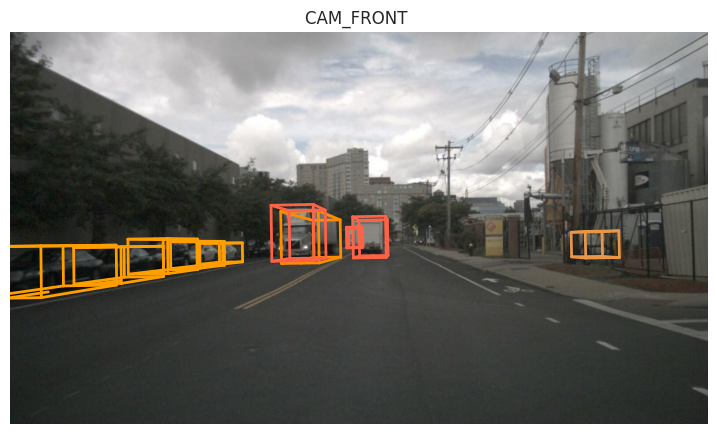

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621915662404.jpg


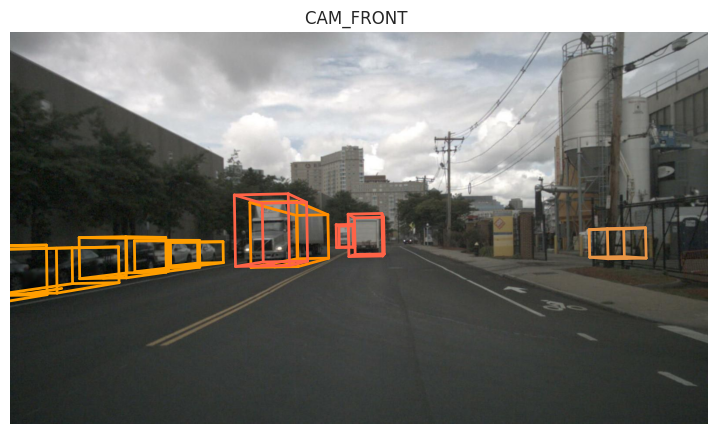

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621916162404.jpg


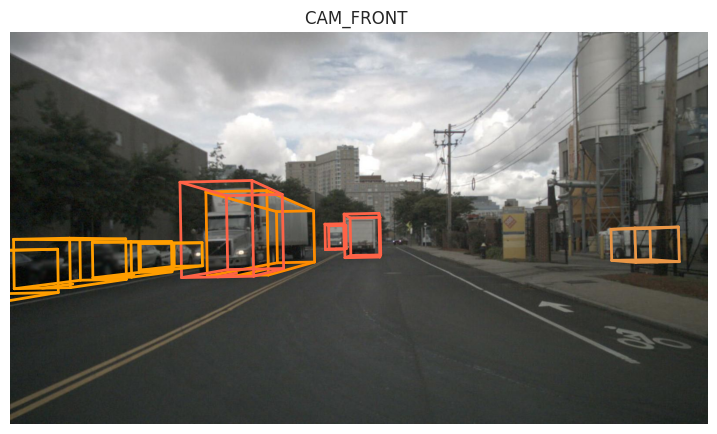

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621916662404.jpg


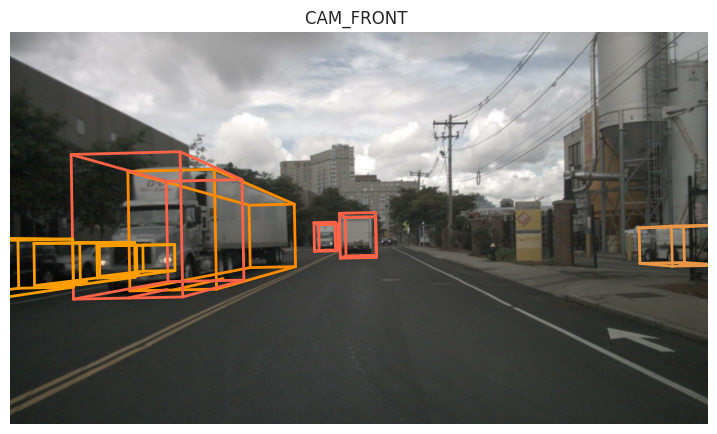

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621917162404.jpg


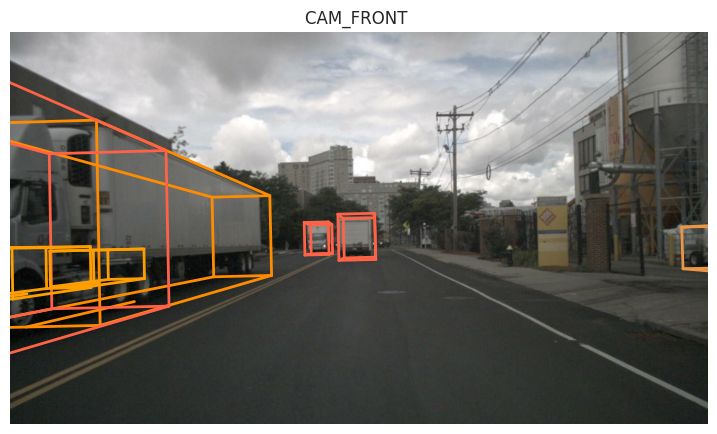

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621918162404.jpg


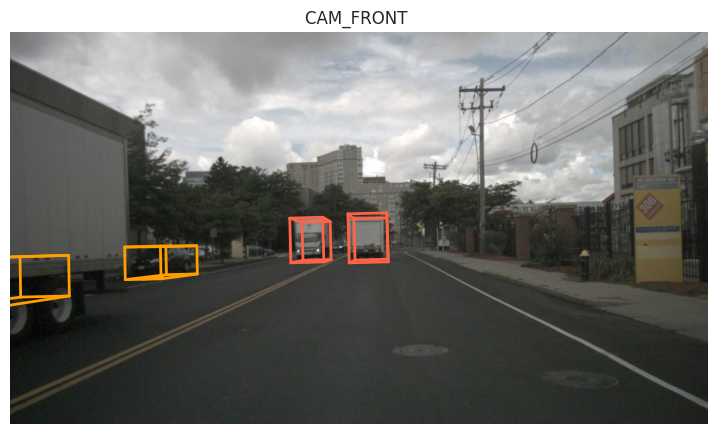

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621918662404.jpg


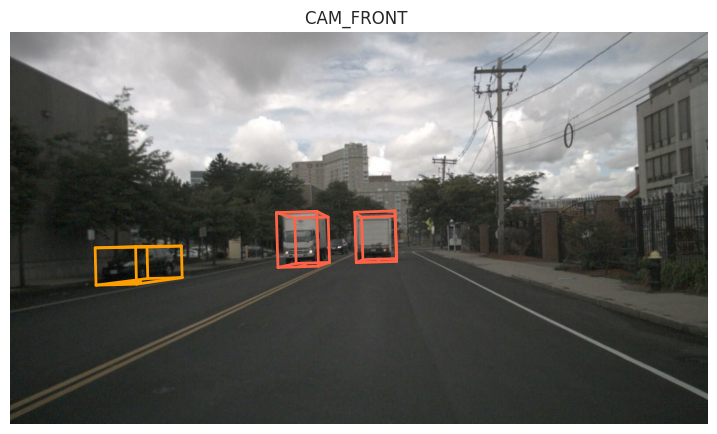

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621919162404.jpg


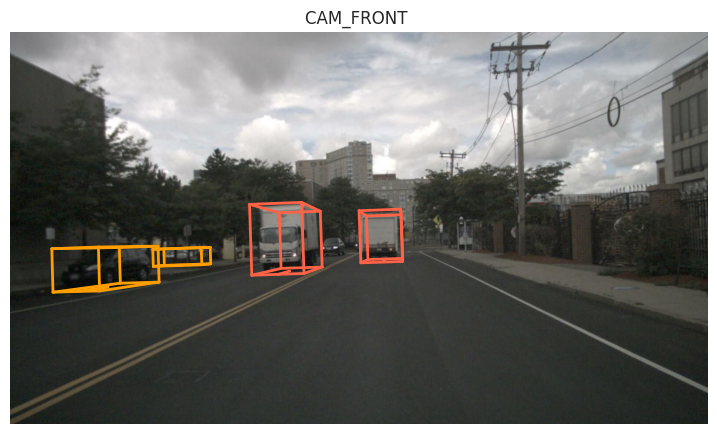

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621919662404.jpg


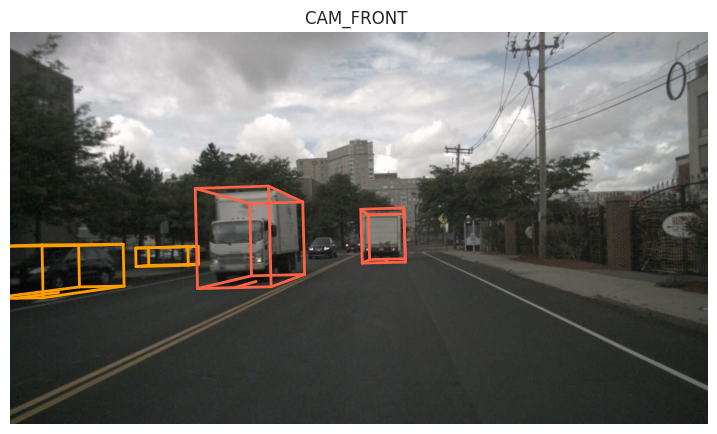

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg


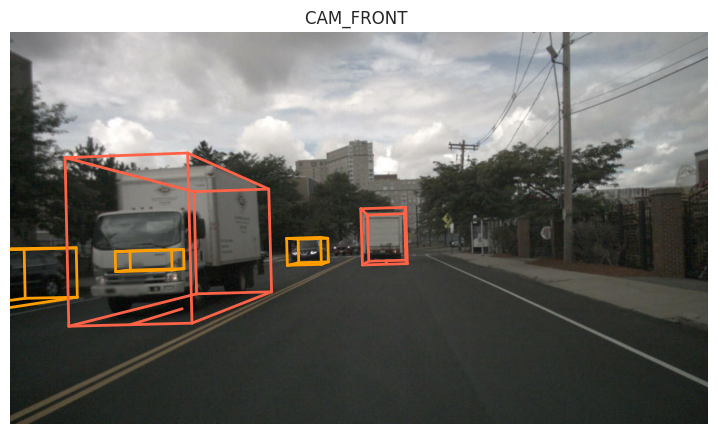

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920662404.jpg


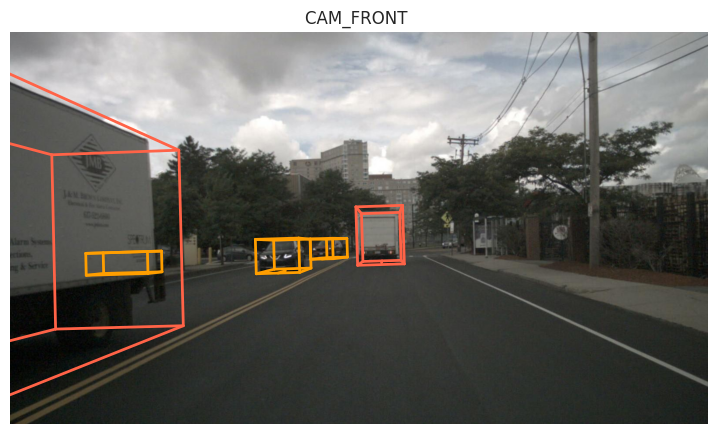

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621921162404.jpg


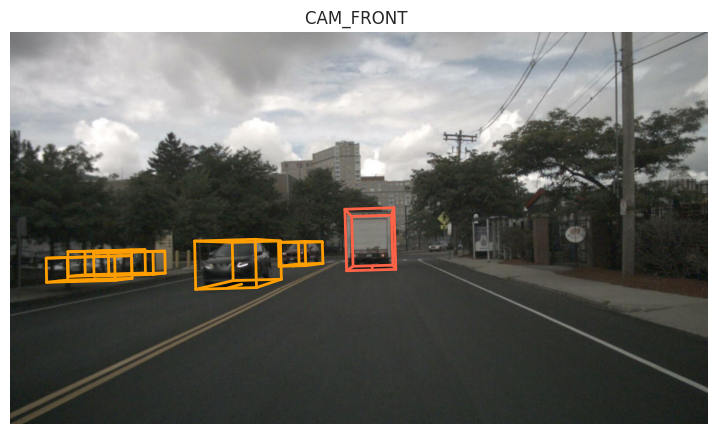

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621921662404.jpg


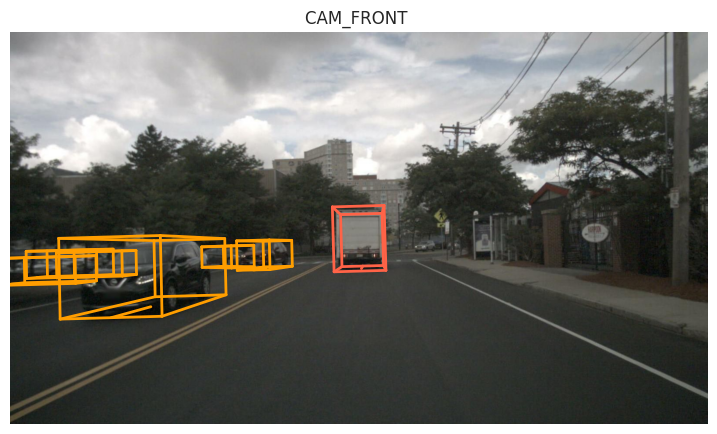

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621922162404.jpg


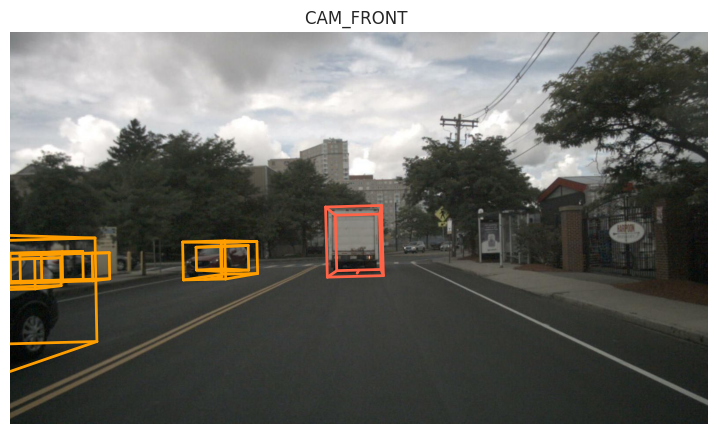

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621922612404.jpg


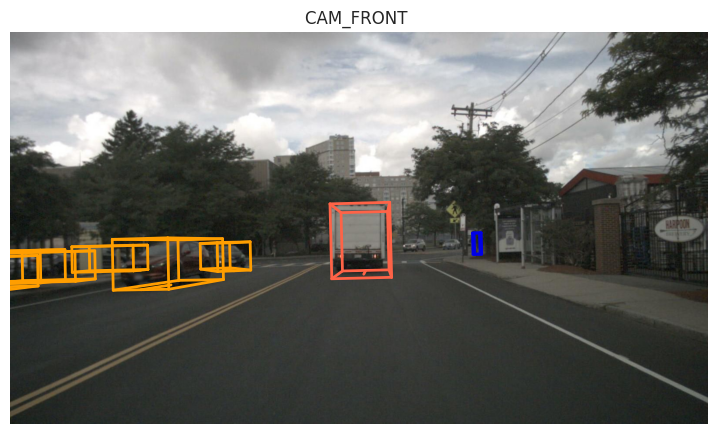

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621923112404.jpg


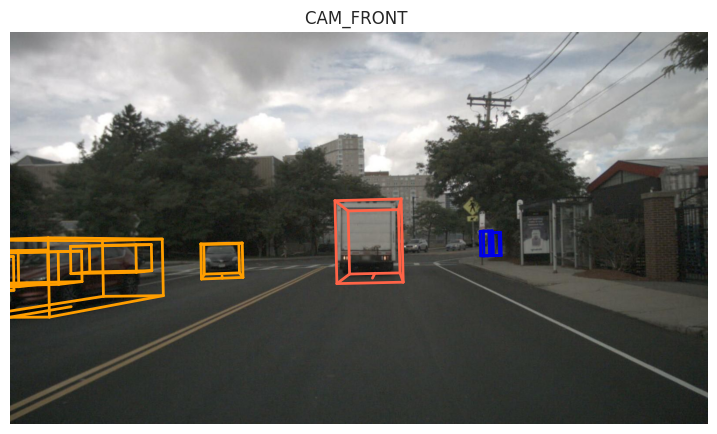

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621923612404.jpg


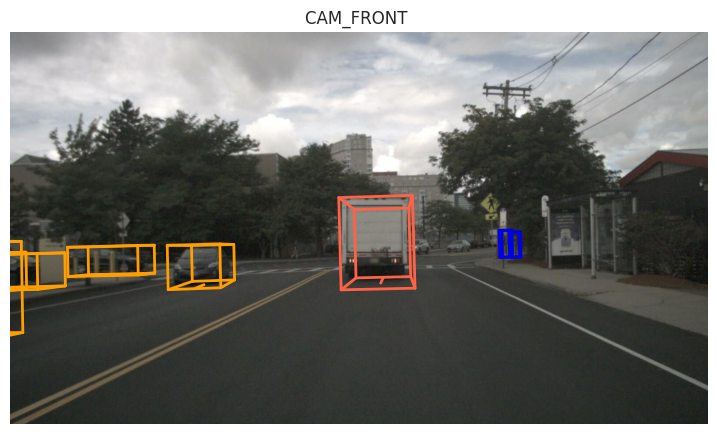

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621924112404.jpg


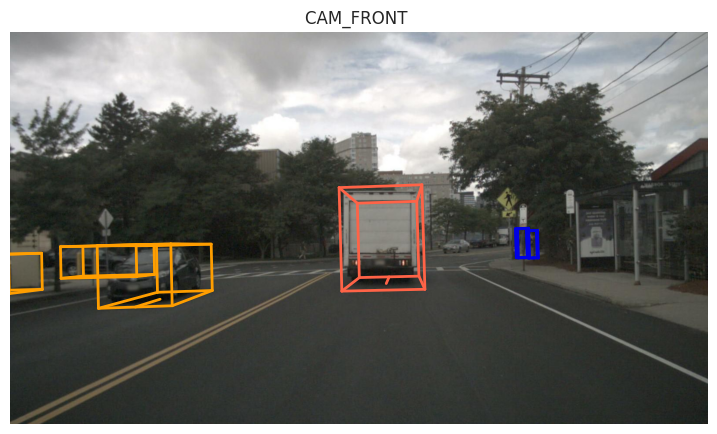

samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621928012404.jpg


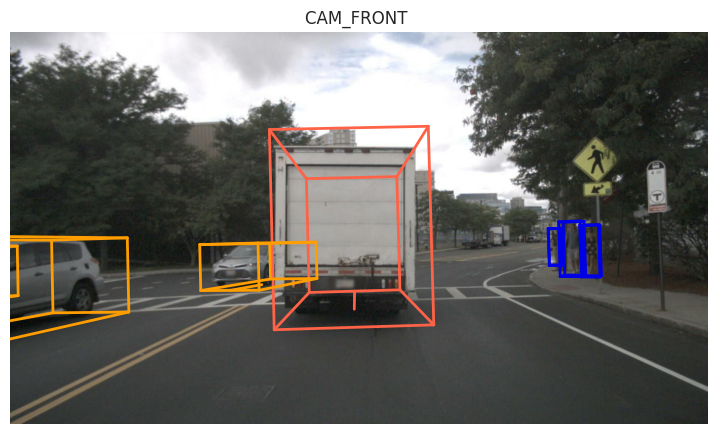

In [27]:
for token in results:
  print(results[token])
  nusc.render_sample_data(token)

In [31]:
############# Validation ####################
expected_imgs = ['sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621918762404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920012404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920112404.jpg',
 'samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920162404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920262404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920362404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920412404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920512404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920612404.jpg',
 'samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621920662404.jpg',
 'samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621923112404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621923162404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621923262404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621923412404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621927912404.jpg',
 'sweeps/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621928262404.jpg']

expected_imgs = list(set([x for x in expected_imgs if "samples" in x]))

missing = 0
missing_images = []
for expected_img in expected_imgs:
    if expected_img not in results.values():
        missing += 1
        # missing_images.append(expected_img)
print("Percentage of expected results missing from query: ", missing, "/", len(expected_imgs), "=", 100 * missing / len(expected_imgs), "%")
# show_images(missing_images, sample=10)

extra = 0
extra_images = {}
for img in results:
    if results[img] not in expected_imgs:
        print(results[img])
        extra += 1
        # extra_images[img] = resultImages[img]
print("Percentage of images in query but not in expected results: ", extra, "/", len(results), "=", 100 * extra / len(results), "%")
# show_images(extra_images.keys(), sample=10)

Percentage of expected results missing from query:  0 / 3 = 0.0 %
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621915112404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621915662404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621916162404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621916662404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621917162404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621918162404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621918662404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621919162404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621919662404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621921162404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-0400__CAM_FRONT__1532621921662404.jpg
samples/CAM_FRONT/n008-2018-07-26-12-13-50-

In [10]:
print(expected_imgs)
print(list(results.values()))

NameError: name 'expected_imgs' is not defined

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

RAW_DATA_DIR = "/work/apperception/data/raw/nuScenes/full-dataset-v1.0/Trainval/"
# Create figure and axes

for img in expected_imgs:
    im = Image.open(RAW_DATA_DIR + img)
    # Display the image
    plt.figure()
    plt.imshow(im)
# plt.show()

In [ ]:
fig, ax = nusc_map.render_layers(nusc_map.non_geometric_layers, figsize=1)

In [ ]:
nusc.list_scenes()